# Santa 2020 - The Candy Cane Contest

Bayesian UCB agent inspired by https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html  
Thompson Sampling agent inspired by https://www.kaggle.com/ilialar/simple-multi-armed-bandit  
Training data collection inspired by https://www.kaggle.com/lebroschar/1000-greedy-decision-tree-model  
Ray support from https://www.kaggle.com/nigelcarpenter/parallel-processing-agent-trials-using-ray  
Pull Vegas agent, I never submitted this since it's not my work, but it was useful to train against https://www.kaggle.com/a763337092/pull-vegas-slot-machines-add-weaken-rate-continue5  

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import joblib
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
import ray

# my helper files
import simulator
import stats

# agents
from agents.classifier import ClassifierAgent
from agents.ensemble import EnsembleAgent
from agents.keras import KerasAgent
from agents.pull_vegas import PullVegasAgent
from agents.random import RandomAgent
from agents.sklearn import SklearnAgent
from agents.thompson import ThompsonAgent
from agents.ucb import UcbAgent


In [ ]:
import psutil

num_cpus = psutil.cpu_count(logical=False)
ray.shutdown()
ray.init(num_cpus=num_cpus)
print(f"Initialized ray with {num_cpus} cpus")

2021-02-21 12:48:37,732	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


Initialized ray with 6 cpus


In [ ]:
# sanity check to make sure everything is working

simulator.smoke_test(ClassifierAgent(100, filename='rl_models/latest.h5'))
simulator.smoke_test(KerasAgent(100, filename='keras_models/l3_u8_relu.h5'))
simulator.smoke_test(SklearnAgent(100, filename='scikit_models/dtr.joblib'))
simulator.smoke_test(EnsembleAgent(100, keras_file='keras_models/l3_u8_relu.h5', scikit_file='scikit_models/dtr.joblib'))
simulator.smoke_test(RandomAgent())

# Load Training Data

Online game data contain the fame state at each step, including the actual payout of each bandit.

In [ ]:
%%time

data = pd.read_parquet('training_data/data.parquet')
print(f"\nLoaded {data.shape[0]} training rows")

# shuffle training data
data = data.sample(frac=1).reset_index(drop=True)

X = data[['step', 'n_pulls', 'n_success', 'n_opp_pulls', 'streak', 'win_streak', 'opp_streak']]
y = data['threshold']
data.head()


Loaded 46113452 training rows
CPU times: user 8.17 s, sys: 2.58 s, total: 10.7 s
Wall time: 11.3 s


,game_id,step,machine,agent,n_pulls,n_success,n_opp_pulls,streak,opp_streak,win_streak,threshold
0,8765201,319,30,1,4,2,3,4,1,0,0.274714
1,9963293,420,58,1,3,1,19,0,1,0,0.399092
2,14292406,912,97,0,15,7,10,1,0,0,0.130753
3,12305211,247,73,0,3,2,4,1,0,1,0.654466
4,12192192,1331,19,0,29,16,27,0,1,1,0.148947


# Sklearn Models

Take training data from top-tier games and find a model that predicts actual payout rates.

I used RMSE as my error benchmark, but it did not perfectly predict head-to-head performance. For example, my best Random Forest fits the dataset with a RMSE of 0.104, very similar to my best Decision Tree. However, the Decision Tree models win easily in a head-to-head match. The end goal is to win, not predict rates with maximum accuracy, so I always simulated matches to find which models performed best.

Decision Trees performed the best by far in my local matches, easily beating Random Forests and Gradient Boosting Regressors.


In [ ]:
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def cross_val_rmse(regressor, X, y):
    cv = -cross_val_score(regressor, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print("Cross val RMSE:", cv)
    print("Mean:", cv.mean())

def feature_importance(regressor, X, y):
    regressor.fit(X, y)
    for name, score in zip(X.columns, regressor.feature_importances_):
        print(name, score)


In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
cross_val_rmse(lr, X, y)

lr.fit(X, y)
joblib.dump(lr, 'scikit_models/lr.joblib')

Cross val RMSE: [0.12015358 0.12003744 0.11991281 0.11990446 0.11994127]
Mean: 0.11998991131973413


['scikit_models/lr.joblib']

In [ ]:
%%time
from sklearn.tree import DecisionTreeRegressor

min_samples_leaf = [40, 80, 100, 120, 160, 200]

for min_leaf in min_samples_leaf:
    print(f"Min leaf {min_leaf}")
    dtr = DecisionTreeRegressor(min_samples_leaf=min_leaf)
    dtr.fit(X, y)
    error = np.sqrt(mean_squared_error(y, dtr.predict(X)))
    print(f"Min leaf {min_leaf} error = {error}")
    joblib.dump(dtr, f"scikit_models/dtr_m{min_leaf}.joblib")


In [ ]:
agents = [
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m40.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m80.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m100.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m120.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m160.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m200.joblib'),
]

simulator.rank_agents(agents, num_games=200, min_games=80)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forests seem to fit the data well, but they lose horribly in actual competitive matches.

# rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=100, max_depth=10)
# rfr.fit(X, y)

# joblib.dump(gbr, 'scikit_models/rfr.joblib')

rfr = joblib.load('scikit_models/rfr.joblib')
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y, rfr.predict(X))))

dtr = joblib.load('scikit_models/dtr.joblib')
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y, dtr.predict(X))))

agents = [
    lambda n: SklearnAgent(n, filename='scikit_models/rfr.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m100.joblib'),
]

simulator.compare_agents(agents, num_games=200, min_games=50)

Random Forest RMSE: 0.10353480616739692
Decision Tree RMSE: 0.10103745235180321
Sklearn - scikit_models/rfr.joblib, margin:0.99
Sklearn - scikit_models/dtr_m100.joblib, margin:0.99
Results after 54 games: 6-48    P(player_1): 0.11±0.08



In [ ]:
min_error = 1
best = None

gbr = GradientBoostingRegressor(max_depth=3, warm_start=True)

for i in range(1, 100):
    gbr.n_estimators=i
    gbr.fit(X, y)
    error = np.sqrt(mean_squared_error(y, gbr.predict(X)))
    print(f"n_estimators: {i}, error: {error}")

    if error < min_error:
        best = i
        min_error = error
        joblib.dump(gbr, 'scikit_models/gbr.joblib')

print("Best n_estimators:", best)

Starting round robin with 4 agents:
Sklearn - scikit_models/lr.joblib, margin:0.99
Sklearn - scikit_models/gbr_best.joblib, margin:0.99
Sklearn - scikit_models/rfr.joblib, margin:0.99
Sklearn - scikit_models/dtr_m100.joblib, margin:0.99

Starting round 1 of 6:
Sklearn - scikit_models/lr.joblib, margin:0.99
Sklearn - scikit_models/gbr_best.joblib, margin:0.99
Results after 60 games: 0-60    P(player_1): 0.00±0.00

Starting round 2 of 6:
Sklearn - scikit_models/lr.joblib, margin:0.99
Sklearn - scikit_models/rfr.joblib, margin:0.99
Results after 60 games: 0-60    P(player_1): 0.00±0.00

Starting round 3 of 6:
Sklearn - scikit_models/lr.joblib, margin:0.99
Sklearn - scikit_models/dtr_m100.joblib, margin:0.99
Results after 60 games: 0-60    P(player_1): 0.00±0.00

Starting round 4 of 6:
Sklearn - scikit_models/gbr_best.joblib, margin:0.99
Sklearn - scikit_models/rfr.joblib, margin:0.99
Results after 90 games: 34-56    P(player_1): 0.38±0.10

Starting round 5 of 6:
Sklearn - scikit_models/gb

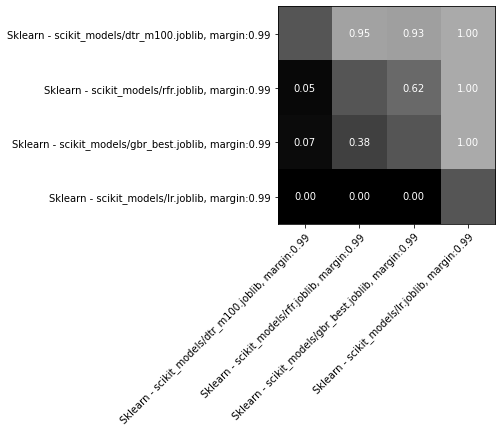

In [ ]:
agents = [
    lambda n: SklearnAgent(n, filename='scikit_models/lr.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/gbr_best.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/rfr.joblib'),
    lambda n: SklearnAgent(n, filename='scikit_models/dtr_m100.joblib'),
]

simulator.round_robin(agents, num_games=200, min_games=60)

# Keras Models

Instead of using a Decision Tree, I tried using a small neural network to predict bandit payout rates.  
I tested different model sizes and found that 3 layers of 12 units performed best, easily well enough for a silver medal.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_model(n_hidden_layers=1,
                 n_units=10,
                 activation='sigmoid',
                 hidden_activation='elu',
                 input_size=4,
                 learning_rate=0.01):
    input_layer = Input(shape=(input_size,))

    for i in range(n_hidden_layers):
        if i == 0:
            m = Dense(n_units, activation=hidden_activation)(input_layer)
        else:
            m = Dense(n_units, activation=hidden_activation)(m)

    m = Dense(1, activation=activation)(m)

    model = Model(inputs=[input_layer], outputs=m)
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model


In [ ]:
model = create_model(
    n_hidden_layers=3,
    n_units=12,
    hidden_activation='relu',
    input_size=7
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from collections import namedtuple

from tensorflow.keras.layers import LeakyReLU

Params = namedtuple('Params', ['layers', 'units', 'activation'])

params_list = [
    Params(3, 12, 'relu'),
    Params(4, 12, 'relu'),
    Params(3, 16, 'relu'),
    Params(4, 16, 'relu'),
]

files = []

for layers, units, activation in params_list:
    print(f"\nLayers:{layers} Units:{units} Activation:{activation}")

    model = create_model(n_hidden_layers=layers,
                         n_units=units,
                         hidden_activation=activation,
                         activation='sigmoid',
                         input_size=7,
                         learning_rate=0.01)

    filename = f"keras_models/l{layers}_u{units}_{activation}.h5"
    files.append(filename)

    early_stopping = EarlyStopping(patience=5)
    mcp = ModelCheckpoint(filename, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=1e-4)

    model.fit(X, y, batch_size=10000, epochs=100, validation_split=0.05, callbacks=[early_stopping, mcp, reduce_lr])


In [ ]:
agents = [
    lambda n: KerasAgent(n, filename='keras_models/l2_u8_relu.h5'),
    lambda n: KerasAgent(n, filename='keras_models/l3_u8_relu.h5'),
    lambda n: KerasAgent(n, filename='keras_models/l3_u12_relu.h5'),
    lambda n: KerasAgent(n, filename='keras_models/l4_u12_relu.h5'),
    lambda n: KerasAgent(n, filename='keras_models/l3_u16_relu.h5'),
    lambda n: KerasAgent(n, filename='keras_models/l4_u16_relu.h5'),
]

simulator.rank_agents(agents, num_games=150, min_games=60)

Keras - keras_models/l3_u8_relu.h5, margin:0.99
Keras - keras_models/l3_u12_relu.h5, margin:0.99
Results after 66 games: 21-43    P(player_1): 0.33±0.12

Keras - keras_models/l2_u8_relu.h5, margin:0.99
Keras - keras_models/l3_u12_relu.h5, margin:0.99
Results after 60 games: 16-44    P(player_1): 0.27±0.11

Keras - keras_models/l2_u8_relu.h5, margin:0.99
Keras - keras_models/l3_u8_relu.h5, margin:0.99
Results after 60 games: 12-48    P(player_1): 0.20±0.10

Keras - keras_models/l3_u16_relu.h5, margin:0.99
Keras - keras_models/l4_u16_relu.h5, margin:0.99
Results after 60 games: 16-43    P(player_1): 0.27±0.11

Keras - keras_models/l4_u12_relu.h5, margin:0.99
Keras - keras_models/l4_u16_relu.h5, margin:0.99
Results after 66 games: 23-42    P(player_1): 0.35±0.12

Keras - keras_models/l4_u12_relu.h5, margin:0.99
Keras - keras_models/l3_u16_relu.h5, margin:0.99
Results after 60 games: 40-20    P(player_1): 0.67±0.12

Keras - keras_models/l3_u12_relu.h5, margin:0.99
Keras - keras_models/l4_u

# Ensembling

Averaging the estimates from a neural network and a decision tree gives a lower RMSE.  
Simple ensembles like this did quite well on the leaderboard for a while, but eventually I improved the neural network enough that it did better on its own.  
Another example of RMSE not predicting actual performance.

In [ ]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model

nn = load_model('keras_models/l3_u12_relu.h5')
dtr = joblib.load('scikit_models/dtr.joblib')

y_pred_nn = nn.predict(X, batch_size=20000)
y_pred_dtr = dtr.predict(X)
y_pred_dtr = np.reshape(y_pred_dtr, (-1, 1))

print("NN Error:", np.sqrt(mean_squared_error(y_pred_nn, y)))
print("DTR Error:", np.sqrt(mean_squared_error(y_pred_dtr, y)))
print("Ensemble Error:", np.sqrt(mean_squared_error((y_pred_nn+y_pred_dtr)/2, y)))

NN Error: 0.10094468149002239
DTR Error: 0.10103745235180321
Ensemble Error: 0.10056106662675557


# Effect of Dataset Size on Performance

Train decision tree and keras models with increasing dataset sizes and see when they plateau.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

data_sizes = [
    10000000,
    20000000,
    35000000,
    40000000,
    44000000,
]

for num_rows in data_sizes:
    X_n = X.head(num_rows)
    y_n = y.head(num_rows)

    model = create_model(n_hidden_layers=3,
                         n_units=12,
                         hidden_activation='relu',
                         activation='sigmoid',
                         input_size=7,
                         learning_rate=0.01)

    filename = f"data_size_test/l3_u12_relu_n{num_rows}.h5"

    early_stopping = EarlyStopping(patience=10)
    mcp = ModelCheckpoint(filename, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-4)

    model.fit(X_n, y_n, batch_size=10000, epochs=150, validation_split=0.05, callbacks=[early_stopping, mcp, reduce_lr])

    dtr = DecisionTreeRegressor(min_samples_leaf=100)
    dtr.fit(X_n, y_n)
    joblib.dump(dtr, f"data_size_test/dtr_m100_n{num_rows}.joblib")



In [ ]:
# Rank Keras agents
agents = [
    lambda n: KerasAgent(n, filename='data_size_test/l3_u12_relu_n10000000.h5'),
    lambda n: KerasAgent(n, filename='data_size_test/l3_u12_relu_n20000000.h5'),
    lambda n: KerasAgent(n, filename='data_size_test/l3_u12_relu_n35000000.h5'),
    lambda n: KerasAgent(n, filename='data_size_test/l3_u12_relu_n40000000.h5'),
    lambda n: KerasAgent(n, filename='data_size_test/l3_u12_relu_n44000000.h5'),
]

simulator.rank_agents(agents, num_games=100, min_games=80)

In [ ]:
simulator.smoke_test(SklearnAgent(100, filename='scikit_models/dtr.joblib'))

agents = [
    lambda n: SklearnAgent(100, filename='data_size_test/dtr_m100_n10000000.joblib'),
    lambda n: SklearnAgent(100, filename='data_size_test/dtr_m100_n20000000.joblib'),
    lambda n: SklearnAgent(100, filename='data_size_test/dtr_m100_n35000000.joblib'),
    lambda n: SklearnAgent(100, filename='data_size_test/dtr_m100_n40000000.joblib'),
    lambda n: SklearnAgent(100, filename='data_size_test/dtr_m100_n44000000.joblib'),
]

simulator.rank_agents(agents, num_games=100, min_games=80)

# Classifier Model

Make a classifier using weights from a regression model and train it using RL

In [ ]:
# create regression model
reg_model = create_model(n_hidden_layers=3, n_units=8, activation='sigmoid', input_size=7, learning_rate=0.01)
reg_model.summary()

reg_model.fit(X, y, batch_size=10000, epochs=100, validation_split=0.05, callbacks=[EarlyStopping(patience=2)])

In [ ]:
# classifier model
# takes in a (num_bandits, num_features) array
# performs 1D convolutions across the first axis using the regression weights
from tensorflow.keras.layers import Conv1D, Softmax

def create_classifier_model(n_hidden_layers=3, n_units=12, activation='sigmoid', hidden_activation='relu', input_size=7):

    input_layer = Input(shape=(None, input_size))
    m = Conv1D(n_units, 1, activation=hidden_activation, trainable=False)(input_layer)
    m = Conv1D(n_units, 1, activation=hidden_activation, trainable=False)(m)
    m = Conv1D(n_units, 1, activation=hidden_activation, trainable=False)(m)
    m = Conv1D(1, 1, activation=activation)(m) # this is the layer trained by RL

    clf_model = Model(inputs=[input_layer], outputs=m)
    opt = Adam(learning_rate=0.01)
    clf_model.compile(optimizer=opt, loss='categorical_crossentropy')

    clf_model.summary()

    for l in clf_model.layers:
        print(l.name, l.trainable)

    return clf_model


In [ ]:
# set classifier layers to use regression weights
clf_model = create_classifier_model(n_hidden_layers=3, n_units=12, hidden_activation='relu', activation=None)

# regression weights need to be reshaped
print("Layer 1 Classifier weights shape:", clf_model.layers[1].get_weights()[0].shape)
print("Layer 1 Regression weights shape:", reg_model.layers[1].get_weights()[0].shape)

for i in range(1, 5):
    reg_weights, reg_biases = reg_model.layers[i].get_weights()
    clf_shape = clf_model.layers[i].get_weights()[0].shape
    reg_weights = np.reshape(reg_weights, clf_shape)
    clf_model.layers[i].set_weights([reg_weights, reg_biases])


# clf_model.save('rl_models/latest.h5')

In [ ]:
fake_data = pd.DataFrame(
            index=range(10),
            columns=['step', 'n_pulls', 'n_success', 'n_opp_pulls', 'streak', 'win_streak', 'opp_streak']
        ).fillna(0)
fake_data.iloc[0] = [1, 1, 1, 0, 1, 1, 0]
pred = clf_model(np.reshape(fake_data.to_numpy(), (1, -1, 7)))[0]
# print(pred.numpy())
pred = reg_model(fake_data.to_numpy())
# print(pred.numpy())


# Policy Gradient Training

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
import random

epsilon = 0.5 # chance of random action

def play_one_step(env, obs, agent, model):
    agent.update_states(obs)
    with tf.GradientTape() as tape:
        tf_probs = model(np.reshape(agent.machine_states.to_numpy(), (1, -1, 7)))
        tf_probs = tf.reshape(tf_probs, -1)
        probs = tf_probs.numpy()
        if random.random() < epsilon:
            action = random.randrange(len(probs))
        else:
            action = int(np.argmax(probs))

        y_target = np.zeros(len(probs))
        y_target[action] = 1
        y_target = tf.constant(y_target)
        loss = tf.keras.losses.categorical_crossentropy(y_target, tf_probs)

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action)

    return obs, reward, done, grads

In [ ]:
def play_multiple_episodes(env, model, n_episodes):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        agent = ClassifierAgent(100, filename='rl_models/latest.h5')
        obs = env.reset()
        for step in range(2000):
            obs, reward, done, grads = play_one_step(env, obs, agent, model)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discount_factor * discounted[step+1]

    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(r, discount_factor) for r in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = np.mean(flat_rewards)
    reward_std = np.std(flat_rewards)

    return [(r - reward_mean) / reward_std for r in all_discounted_rewards]

In [ ]:
rewards = [[0, 1, 5, 10, 3], [-10, 5, -20, 5]]

print(discount_rewards(rewards[0], 0.97))
print(discount_rewards(rewards[1], 0.97))
print(discount_and_normalize_rewards(rewards, 0.97))

In [ ]:
import random
from tqdm import tqdm

from kaggle_environments import make

discount_factor = 0.97
n_episodes_per_update = 3
start_iteration = 1
num_iterations = 50
starting_model = 'rl_models/latest.h5'

optimizer = keras.optimizers.Adam(lr=0.01)

opponents = [
    lambda n: PullVegasAgent(n),
    lambda n: ClassifierAgent(n, filename='rl_models/latest.h5')
]

opponent = None
def opp_step(obs, config):
    global opponent
    if obs.step == 0:
        opponent = random.choice(opponents)(100)
    return opponent.step(obs, config)

env = make("mab", debug=True)
trainer = env.train([None, opp_step])

model = keras.models.load_model(starting_model)
# for l in model.layers:
#     l.trainable = True

for i in tqdm(range(start_iteration, start_iteration+num_iterations)):
    all_rewards, all_grads = play_multiple_episodes(trainer, model, n_episodes_per_update)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []

    for var_index in range(len(model.trainable_variables)):
        var_grads = []
        for episode_index, final_rewards in enumerate(all_final_rewards):
            for step, final_reward in enumerate(final_rewards):
                grad = all_grads[episode_index][step][var_index]
                var_grads.append(final_reward * grad)

        mean_grads = tf.reduce_mean(var_grads, axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    model.save(f"rl_models/{i}.h5")
    model.save(f"rl_models/latest.h5")



In [ ]:
agents = [
#     lambda n: EnsembleAgent(n, alpha=0.5, keras_file='keras_models/l3_u8_relu.h5', scikit_file='scikit_models/dtr.joblib'),
#     lambda n: ClassifierAgent(n, filename='rl_models/130.h5'),
#     lambda n: KerasAgent(n, filename='keras_models/l3_u8_relu.h5'),
    lambda n: ClassifierAgent(n, filename='rl_models/latest.h5'),
    lambda n: ClassifierAgent(n, filename='rl_models/0.h5'),
#     lambda n: ClassifierAgent(n, filename='rl_models/relu/21.h5'),
#     lambda n: UcbAgent(),
#     lambda n: PullVegasAgent(100),
]

round_robin(agents, num_games=100, min_games=20)

# Testing in Kaggle Environment
Not ideal for performance testing, but double-checks that they'll work online

In [ ]:
from kaggle_environments import make
env = make("mab", debug=True)

env.reset()
env.run([ "decision_tree.py", "keras_agent.py"])
print(env)
env.render(mode="ipython", width=800, height=700)


# Submit Agent

Quick script to make a tar.gz file and upload it to kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi


def submit_agent(agent_file, keras_file, sub_name, message, scikit_file = None):

    assert os.path.exists(agent_file), "Agent file not found"
    assert os.path.exists(keras_file), "Keras file not found"

    os.system(f"cp {agent_file} main.py")
    os.system(f"cp {keras_file} model.h5")
    if scikit_file:
        assert os.path.exists(scikit_file), "Scikit file not found"

        os.system(f"cp {scikit_file} model.joblib")
        os.system(f"tar cvfz submissions/{sub_name}.tar.gz main.py model.h5 model.joblib")
        os.system(f"rm model.joblib")
    else:
        os.system(f"tar cvfz submissions/{sub_name}.tar.gz main.py model.h5")

    os.system(f"rm main.py")
    os.system(f"rm model.h5")

    api = KaggleApi()
    api.authenticate()

    api.competition_submit(f"submissions/{sub_name}.tar.gz", message,'santa-2020')

version='l4_u16_relu'
# submit_model("agents/classifier.py", f"rl_models/{version}.h5", f"classifier_elu_{version}", f"RL classifier with ELU activation after {version} iterations")
# submit_agent("agents/keras.py", f"keras_models/{version}.h5", f"keras_{version}", f"Keras Regressor {version}")
# submit_agent("agents/ensemble.py",
#              f"keras_models/{version}.h5",
#              f"ensemble_a05_{version}_dtr",
#              f"Ensemble a0.5 {version} DTR",
#              scikit_file='data_size_test/dtr_m100_n30000000.joblib')

